In [1]:
# helper
def plot_wrapper(plot_object, title, subtitle, xlabel, ylabel, xtick_rotation = None):
    """
    Simple function to set title, labels etc. of a seaborn plot. Helps with readability.
    The function prints the plot.
    
    Arguments
    ---------
    :param plot_object:    a seaborn plot object
    :param title:          str, sets a bold title
    :param subtitle:       str, sets a subtitle
    :param xlabel:         str, replaces xlabel
    :param ylabel:         str, replaces ylabel
    :param xtich_rotation: int, rotates xticks  
    
    Returns
    -------
    :return None:          the function prints a plot
    """
    g = plot_object

    # Title, Subtitle and Axis
    g.text(x=0.5, 
            y=1.06, 
            s=title, 
            fontsize=10, weight='bold', ha='center', va='bottom', transform=g.transAxes)
    g.text(x=0.5, 
            y=1.01, 
            s=subtitle, 
            fontsize=10, alpha=0.75, ha='center', va='bottom', transform=g.transAxes)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if xtick_rotation is not None:
        plt.xticks(rotation=xtick_rotation)
    plt.show()

# Location Classification
The goal of this notebook is to find important lab tests per location of (positive) uveitis patients. 
The hypothesis is that an anterior inflammation can be identified by a different subset of lab tests as for example posterior inflammations. 
This would allow to order a subset of all possible lab tests after the location of the inflammation has been located to identify uveitis. One approach would be to train a model per location.

Steps:

1. Get Subset of Data (Target Featue: Location, Input Features: Lab Results) 
2. Define suitable Algorithms for Binary Classification (e.g. Logistic Regression, etc.)
3. Call preprocessing pipe with appropriat parameters for the current algorithm
4. Fit Model
5. Extract and Discuss important Features

In [2]:
RANDOM = 43

import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

# sklearn standard imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Binarizer, LabelEncoder, Normalizer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
# !pip install scikit-optimize # = skopt
from skopt import BayesSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

# import of pipe module
os.chdir('../preprocessing/')
import pipe

os.chdir('../machine_learning/')

## Data Preparation
To predict the location of an inflammation, we need to drop all columns that contain information about the location. Meta-Information about the patient will also be dropped.

In [3]:
# calling preprocessing function

# num_to_cat = True: Range Date is now dtype Category 
# drop_filter: Drop every column that is not a lab test

df = pipe.preprocessing_pipe(num_to_cat   = False,
                             drop_filter  = ['hla', 'ac_', 'vit_', 'gender','race', 'cat','specific_diagnosis'],
                             loc_approach = 'multi',
                             binary_cat   = True,
                             nan_percentage = 0.2,
                             hotencode_gender = True) 
df.head()

,loc,calcium,lactate_dehydrogenase,"c-reactive_protein,_normal_and_high_sensitivity",wbc,rbc,hemoglobin,hematocrit,mcv,mch,...,"lysozyme,_plasma",anti-ccp_ab,anti-ena_screen,antinuclear_antibody,dna_double-stranded_ab,rheumatoid_factor,hbc__ab,hbs__ag,hcv__ab,uveitis
0,anterior,2.27,184,1.830,6.91,4.97,14.6,41.4,83.3,29.4,...,3.0,0.0,0.0,0.0,0.0,0,0,0,0,False
1,intermediate,2.32,209,0.150,4.24,4.22,11.0,36.0,85.3,26.1,...,NaN,0.0,0.0,0.0,0.0,0,0,0,0,True
2,panuveitis,2.44,194,0.137,6.38,4.31,13.6,38.7,89.8,31.6,...,4.8,0.0,0.0,0.0,0.0,0,0,0,0,True
3,anterior,2.45,156,3.500,5.24,4.82,14.6,43.6,90.5,30.3,...,NaN,0.0,0.0,0.0,0.0,0,0,0,0,True
4,anterior,2.28,175,1.000,8.31,4.72,14.0,40.7,86.2,29.7,...,4.5,0.0,0.0,0.0,1.0,0,0,0,0,True


### Split into uveitis and not_uveitis data

In [4]:
df_uv_pos = df[df.uveitis == True]
df_uv_neg = df[df.uveitis != True]

# Multiclass classification
In this section we try to predict the location of an inflammation of uveitis positive patients. For this we remove records of non uveitis patients.
These models can be used as a comparison for the binary classification (see next chapter)

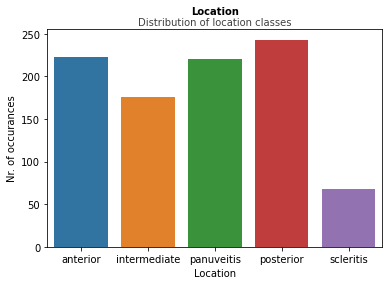

In [5]:
df_uv_pos_clean = df_uv_pos.dropna(subset=['loc']) # drop records with missing location data (3)
g = sns.countplot(x=df_uv_pos_clean['loc'])
plot_wrapper(g, 'Location','Distribution of location classes','Location','Nr. of occurances')

**Discussion** The target feature contains 5 classes. The three missing values have been removed. We can see that. with the execption of the location 'scleritis', that the classes are somewhat balanced.

### Upsampeld Data

In [6]:
#################### TODO: ADD UPSAMPLING

#### Train-Test Split
Trainingset contains 75% of data. The target feature is the loc (Location)-Feature. 
The target feature contains 3 missing values. We initially drop these records.

In [7]:
# train_test_split
X = df_uv_pos_clean.drop(columns=['loc','uveitis'])
y = df_uv_pos_clean['loc']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM, stratify = None)

#### Imputation and Encoding

In [8]:
# filter for numeric and categorical features
numerics = ['Int64','float64']
category = ['category','bool']

# select list of numeric and categorical features
numeric_features = X.select_dtypes(include=numerics).columns.tolist()
categorical_features = X.select_dtypes(include=category).columns.tolist()

# define imputer strategy (consult sklarn SimpleImputer and StandardScaler documentation for options)
imputer = {'categorical':{'strategy':'most_frequent','fill_value':'most_frequent'}, 'numerical':{'strategy':'median', 'fill_value':'mean'}}
imputer_encoder_no_onehot = pipe.impute_and_encode(categorical_features, numeric_features, imputer, one_hot=False)
imputer_encoder_onehot = pipe.impute_and_encode(categorical_features, numeric_features, imputer, one_hot=True, knn_impute=True)
imputer_encoder_onehot_knn = pipe.impute_and_encode(categorical_features, numeric_features, imputer, one_hot=True, knn_impute=True)
imputer_encoder_no_onehot_knn = pipe.impute_and_encode(categorical_features, numeric_features, imputer, one_hot=False, knn_impute=True)

## Baseline Model

In [9]:
dummy = DummyClassifier(strategy='prior', random_state=RANDOM)
pipeline = Pipeline(steps=[('preprocessor', imputer_encoder_no_onehot),
                      ('classifier', dummy)])
pipeline.fit(X_train, y_train)
print(f'Accuracy Dummy Classifier: {pipeline.score(X_test, y_test)}')
print(f'Class probabilites: {pipeline.predict_proba(X_test)[0:1][0]}')

Accuracy Dummy Classifier: 0.27896995708154504
Class probabilites: [0.23529412 0.20659971 0.2266858  0.2553802  0.07604017]


This model acts as our basline. This model takes in the prior probability of a class occuring in the trainingset, and recommends blindly based on these probabilites. 

## Decision Tree

In [10]:
# import decision tree
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from dtreeviz.trees import dtreeviz

In [11]:
from sklearn.metrics import make_scorer, f1_score, precision_score, accuracy_score

# supress warnings of estimator fit failed
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

dectree = DecisionTreeClassifier()

# without one_hot_encoded data
pipeline = Pipeline(steps=[
    ('prep', imputer_encoder_no_onehot),
    ('tree', dectree)
])

# hyperparameterspace
parameters = {
    'tree__criterion':['gini','entropy'],
    'tree__splitter' :['best','random'],
    'tree__max_depth':np.arange(2,10,8),
    'tree__min_samples_split':[int(i) for i in np.arange(2,20,10)],
    'tree__random_state':[RANDOM],
    'tree__class_weight':['balanced'] # {'anterior':0.23529412 , 'intermediate':0.20659971 , 'panuveitis':0.2266858  , 'posterior':0.2553802  , 'scleritis':0.07604017}]
}

# create scorer
scorer = make_scorer(precision_score, average = 'weighted')

# random search
rv = BayesSearchCV(pipeline, parameters, cv = 10, scoring=scorer)
rv.fit(X_train, y_train)
print('Best Parameters:')
print(rv.best_params_)

Best Parameters:
OrderedDict([('tree__class_weight', 'balanced'), ('tree__criterion', 'gini'), ('tree__max_depth', 2), ('tree__min_samples_split', 6), ('tree__random_state', 43), ('tree__splitter', 'best')])


In [12]:
rv.score(X_test,y_test)

0.2810162309734482

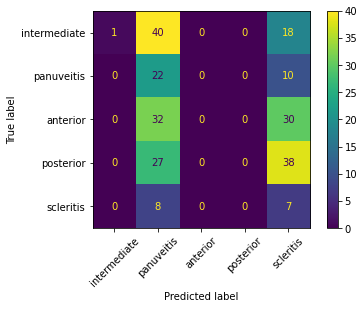

In [13]:
ConfusionMatrixDisplay(confusion_matrix(y_test, rv.best_estimator_.predict(X_test)), display_labels=df_uv_pos_clean['loc'].unique()).plot()
plt.xticks(rotation=45)
plt.show()

## Random Forest

In [14]:
from sklearn.ensemble import RandomForestClassifier


rantree = RandomForestClassifier(n_jobs=-1, random_state=RANDOM)

# without one_hot_encoded data
pipeline = Pipeline(steps=[
    ('prep', imputer_encoder_no_onehot),
    ('tree', rantree)
])

# hyperparameterspace
parameters = {
    'tree__n_estimators':[100,1000],
    'tree__max_features':['log2', 'sqrt', 'auto'],
    'tree__oob_score':[True,False]
}

# create scorer
scorer = make_scorer(precision_score, average = 'weighted')

# bayes search
bv = BayesSearchCV(pipeline, parameters, cv = 10, scoring=scorer)
bv.fit(X_train, y_train)
print('Best Parameters:')
print(bv.best_params_)

Best Parameters:
OrderedDict([('tree__max_features', 'auto'), ('tree__n_estimators', 487), ('tree__oob_score', True)])


In [15]:
bv.best_estimator_.score(X_test,y_test)

0.3218884120171674

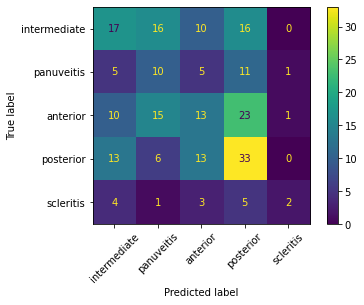

In [16]:
ConfusionMatrixDisplay(confusion_matrix(y_test, bv.best_estimator_.predict(X_test)), display_labels=df_uv_pos_clean['loc'].unique()).plot()
plt.xticks(rotation=45)
plt.show()

## KNN

In [17]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_jobs=-1)

# without one_hot_encoded data
pipeline = Pipeline(steps=[
    ('prep', imputer_encoder_no_onehot),
    ('knn', knn)
])

# hyperparameterspace
parameters = {
    'knn__n_neighbors':np.arange(5,100,10),
    'knn__weights':['uniform', 'distance'],
    'knn__algorithm':['auto','ball_tree','kd_tree','brute']
}

# create scorer
# scorer = make_scorer(precision_score, average = 'weighted')

# bayes search
bv = BayesSearchCV(pipeline, parameters, cv = 10)
bv.fit(X_train, y_train)
print('Best Parameters:')
print(bv.best_params_)

Best Parameters:
OrderedDict([('knn__algorithm', 'ball_tree'), ('knn__n_neighbors', 15), ('knn__weights', 'distance')])


In [18]:
bv.best_estimator_.score(X_test,y_test)

0.296137339055794

In [19]:
################### TODO: TEST MORE CLASSIFIERS

# Binary classification